In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

C:\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('E.csv', encoding='utf8', dtype=object)

In [7]:
df.head(1)['Name'].values

array(['Age of Myth: Book One of The Legends of the First Empire'],
      dtype=object)

In [96]:
len(df)

6309

In [97]:
dfAdult = df[df['Name'].str.contains("sex|erotic|gay|lesbian|porn|adult|hot|intimate|romance|romantic|seduce|nsfw|love", case=False)==True]

In [98]:
len(dfAdult)

279

In [99]:
dfAdult = dfAdult.assign(label=1)

In [100]:
dfAdult.head(3)

,Name,Author,Publisher,Publishing_Date,Format,Pages,Rating,label
9,Fantasy Flower Garden: Adult Coloring Book of ...,C L Aldridge,CreateSpace Independent Publishing Platform,2018-3-3,Paperback,102.0,5.0,1
31,"The Marechal Chronicles: Volumes I, II and III...",Aim\u00e9lie Aames,CreateSpace Independent Publishing Platform,2014-5-20,Paperback,278.0,3.3,1
36,Arousal: The Secret Logic of Sexual Fantasies,Michael J. Bader,St. Martin's Griffin,2003-1-18,Kindle,304.0,4.1,1


In [101]:
df.drop(dfAdult.index, axis=0,inplace=True)

In [102]:
len(df)

6030

In [103]:
df = df.assign(label=0)

In [116]:
dfLabel = pd.concat([df, dfAdult])

In [117]:
len(dfLabel)

6309

In [118]:
titles = dfLabel['Name'].tolist()

In [123]:
labels = np.asarray(dfLabel['label'].tolist())

In [124]:
maxSequenceLength = 250
maxWords = 5000

In [125]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(titles)
sequences = tokenizer.texts_to_sequences(titles)
word_index = tokenizer.word_index

In [126]:
len(word_index)

8024

In [127]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [128]:
data.shape

(6309, 250)

In [129]:
labels.shape

(6309,)

In [130]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [131]:
data = data[indices]
labels = labels[indices]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [133]:
len(X_train), len(y_train)

(5047, 5047)

In [134]:
len(X_test), len(y_test)

(1262, 1262)

In [140]:
embeddingDim = 100

In [141]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation=activations.relu))
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(1, activation=activations.sigmoid))

model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=['accuracy'])

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                400016    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 900,593
Trainable params: 900,593
Non-trainable params: 0
_________________________________________________________________


In [143]:
history = model.fit(X_train, y_train,
                    epochs=4,
                    batch_size=32, 
                    validation_split=0.2)

Train on 4037 samples, validate on 1010 samples
Epoch 1/4
4037/4037 [==============================] - 3s 632us/step - loss: 0.1957 - acc: 0.9477 - val_loss: 0.1585 - val_acc: 0.9584
Epoch 2/4
4037/4037 [==============================] - 2s 482us/step - loss: 0.1170 - acc: 0.9633 - val_loss: 0.1289 - val_acc: 0.9653
Epoch 3/4
4037/4037 [==============================] - 2s 460us/step - loss: 0.0503 - acc: 0.9849 - val_loss: 0.1091 - val_acc: 0.9703
Epoch 4/4
4037/4037 [==============================] - 2s 456us/step - loss: 0.0246 - acc: 0.9926 - val_loss: 0.1196 - val_acc: 0.9693


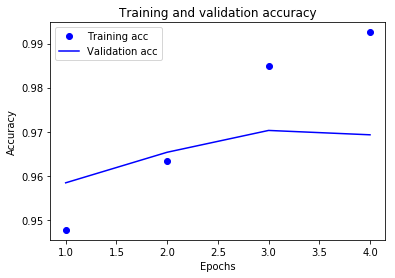

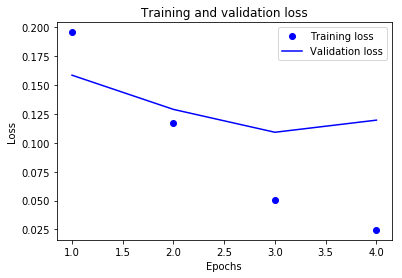

In [144]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [145]:
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]

1262/1262 [==============================] - 0s 181us/step


In [146]:
loss

0.05760272724182004

In [147]:
accuracy

0.9857369255150554

In [148]:
def classifyTuples(model, tokenizer, value):
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=250)
    predictions = model.predict(testData)
    return int(predictions[0] >= 0.5)

In [149]:
ourLabels = []
for row in titles:
    label = classifyTuples(model, tokenizer, row)
    ourLabels.append({row:label})

In [150]:
len(ourLabels)

6309

In [151]:
ourLabels

[{'Age of Myth: Book One of The Legends of the First Empire': 0},
 {'Rise of the Dragons (Kings and Sorcerers--Book 1)': 0},
 {'The Book of Deacon (Volume 1)': 0},
 {"A Quest of Heroes: Book #1 in the Sorcerer's Ring": 0},
 {'Fantasia: An Algerian Cavalcade': 0},
 {'The Fantasy Baseball Black Book 2018 (Fantasy Black Book)': 0},
 {'Fantasy Baseball for Smart People: How to Use Math and Psychology to Win at DFS': 0},
 {'Final Fantasy XV Guide: Walkthrough, Side Quests, Bounty Hunts, Food Recipes, Cheats, Secrets and More': 0},
 {'Power, Faith, and Fantasy: America in the Middle East: 1776 to the Present': 0},
 {'The Wolf of the North: Wolf of the North Book 1 (Volume 1)': 0},
 {'Fantasy of Freedom (The Tainted Accords) (Volume 4)': 0},
 {'Fantasia in D minor, K. 397: Sheet (Alfred Masterwork Edition)': 0},
 {'Basic Fantasy Role-Playing Game 3rd Edition': 0},
 {'Thinblade: Sovereign of the Seven Isles: Book One': 0},
 {'Empire of Storms (Throne of Glass)': 0},
 {'Grimgar of Fantasy and A

In [164]:
df.isnull().sum()

Name                 0
Author              10
Publisher          263
Publishing_Date    324
Format              81
Pages              364
Rating             179
label                0
dtype: int64

In [165]:
true = []
predicted = []
for i in ourLabels:
    title = list(i.keys())[0]
    try:
        true.append(df[df['Name'] == title]['label'].values[0])
        predicted.append(list(i.values())[0])
    except:
        continue

In [167]:
len(predicted)

6030

In [168]:
len(true)

6030

In [169]:
from sklearn.metrics import classification_report

In [170]:
print(classification_report(true, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6030
          1       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00      6030



c:\python35\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [171]:
289/6309

0.045807576478047236

In [172]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.
